# Classification Algorithms

## Perceptron

Though we implemented a **perceptron** from scratch, we can train one directly from **Scikit Learn**. We will continue using the *Iris* dataset.

In [4]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

To better measure performance we have to split the data into **training** and **test** set.

In [5]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

/home/alan/anaconda2/envs/python-machinelearning/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


As we may recall, standardizing features is a best practice before training.

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Since the perceptron is already implemented efficiently, this time we can use all 3 classes and not just 2.

In [7]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(n_iter=40, eta0=0.01, random_state=0) # with random_state=0 we get reproducibility
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.01, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [8]:
y_pred = ppn.predict(X_test_std)
print("Misclassified samples: {0}".format((y_test != y_pred).sum()))

Misclassified samples: 4


We got just 4 errors, but we can get even more performance metrics via the homonym module

In [9]:
from sklearn.metrics import accuracy_score
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.9111111111111111


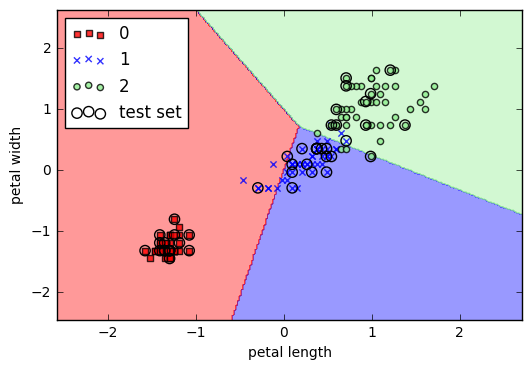

In [10]:
%matplotlib inline
from plot_decision_regions import plot_decision_regions
import matplotlib.pyplot as plt
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined_std, y_combined, classifier=ppn, test_idx=range(105, 150))
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend(loc="upper left")

## Logistic Regression

The **Perceptron** can converge only if classes are linearly separable. To partially avoid this pitfall we will use **Logistic Regression**.

To understand Logistic Regression we have to start from the **odds ratio** which is the odds in favour of a particular event. Basically we have: $\frac{p}{(1-p)}$ where $p$ stands for the probability of the positive event.

We can further define the **logit** function which is the logarithm of the odds ratio:

$$
logit(p)=log \frac{p}{(1-p)}
$$

The logit function takes input values in the range 0 to 1 and transforms them to values over the entire real number range. In this way we can use these values to express a linear relationship between feature values and **log-odds** (logit).

$$
logit(p(y=1|x)) = w_{0}x_{0} + w_{1}x_{1} + \dots + w_{m}x_{m} = \sum_{i=0}^{m}w_{i}x_{i} = \textbf{w}^T \textbf{x}
$$

Here $p(y=1|x)$ is the conditional probability that a particular sample belongs to class 1 given its features x. What we really want to know is predicting the probability that a certain sample belongs to a particular class, which is the inverse of the logit. This is the characteristical **sigmoid** function:

$$
\phi(z) = \frac{1}{1+e^{-z}}
$$

Here $z$ is the net input, or the linear combination of weights and sample features -> $\textbf{w}^T\textbf{x}$.

Let's plot the sigmoid for some values in the range -7 to 7.

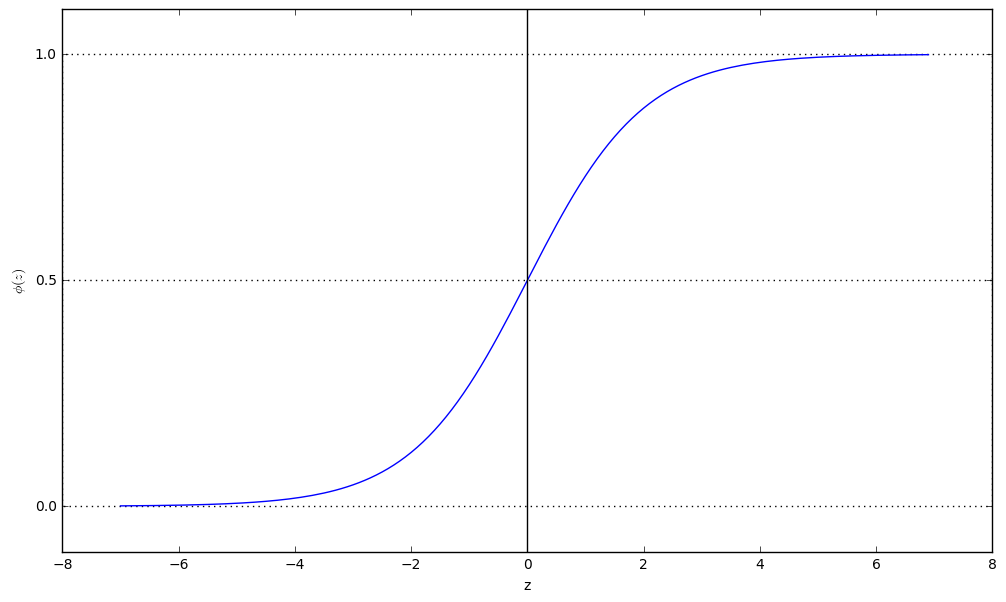

In [11]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (12.0, 7.0)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color="k")
plt.axhspan(0.0, 1.0, facecolor="1.0", alpha=1.0, ls="dotted")
plt.axhline(y=0.5, ls="dotted", color="k")
plt.yticks([0.0, 0.5, 1.0])
plt.ylim(-0.1, 1.1)
plt.xlabel("z")
plt.ylabel("$\phi (z)$")
plt.show()

We will implement Logistic Regression via **Scikit-Learn** since it's already optimized and supports multiclass off-the-shelf.

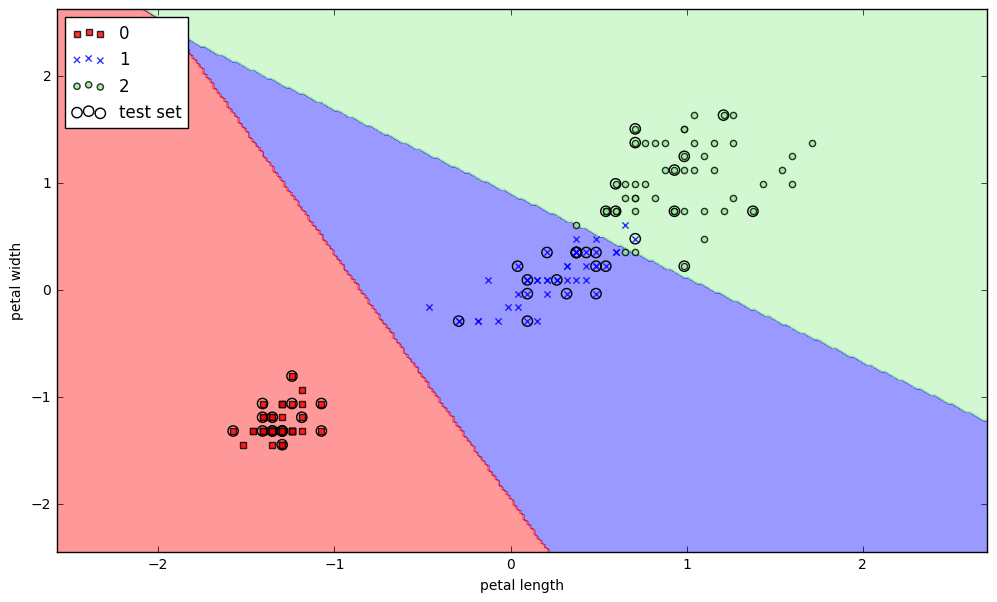

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105,150))
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend(loc="upper left")
plt.show()

We can predict class probabilities via the `predict_proba` method

In [13]:
lr.predict_proba(X_test_std[0,:].reshape(1, -1)).round(3)

array([[ 0.   ,  0.063,  0.937]])

## Regularization

To limit overfitting we can use **regularization**. The concept behind it is to introduce additional info to penalize extreme parameter weights, the most common form of regularization is **L2 regularization** which can be written as:

$$
\frac{\lambda}{2}|w|^2 = \frac{\lambda}{2}\sum_{j=1}^{m}w_{j}^{2}
$$

Here $\lambda$ is the regularization parameter which controls fitting and must be added to the cost function. When we fitted the logistic regression above, $C$ indicates the inverse of $\lambda$: $C=\frac{1}{\lambda}$.

So by decreasing $C$ we are increasing regularization strength. Let's visualize what happens

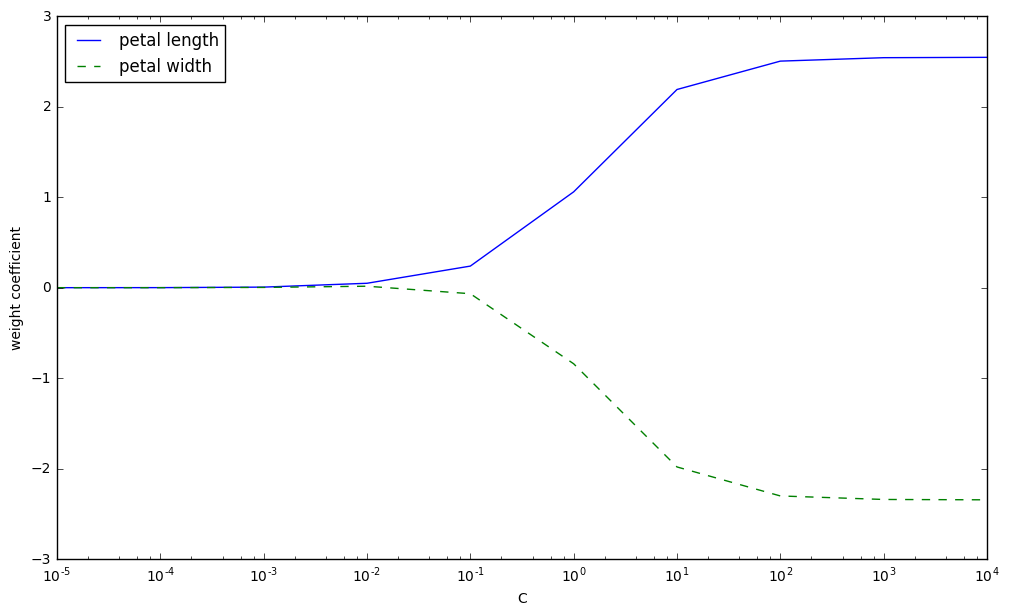

In [14]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0], label="petal length")
plt.plot(params, weights[:, 1], linestyle="--", label="petal width")
plt.ylabel("weight coefficient")
plt.xlabel("C")
plt.legend(loc="upper left")
plt.xscale("log")
plt.show()

We fitted 10 logistic regression models with different values for $C$, as we can see by decreasing $C$ we shrink the weight coefficient, this means that by increasing regularization strength we push weights towards 0.

## Support Vector Machines

**SVM** can be considered as an extension of the perceptron, instead of minimizing classification errors, we maximize the margin. 

To understand margin maximization we start from *positive* and *negative* hyperplanes that are parallel to the decision boundary:

$$
w_{0} + \textbf{w}^T\textbf{x}_{pos}=1 \\\
w_{0} + \textbf{w}^T\textbf{x}_{neg}=-1
$$

If we subtract the linear equations above we get:

$$
\textbf{w}^T(\textbf{x}_{pos}-\textbf{x}_{neg})=2
$$

We can normalize this by the length of the vector **w**:

$$
||\textbf{w}||=\sqrt{\sum_{j=1}^{m}w_{j}^{2}}
$$

So we arrive at the following:

$$
\frac{\textbf{w}^T(\textbf{x}_{pos}-\textbf{x}_{neg})}{||\textbf{w}||}=\frac{2}{||\textbf{w}||}
$$

Now the objective function of the **SVM** becomes the maximization of the margin by maximizing $\frac{2}{||w||}$, but in practice it's easier to minimize the reciprocal $\frac{1}{2}||w||^2$

## Nonlinearly Separable Case

To deal with the fact that the previous will never converge in case of nonlinearly separable data. We will use the $\xi$ (slack) variable and as previously the $C$ value for regularization.

In this case with $C$ we control the penalty for misclassification.

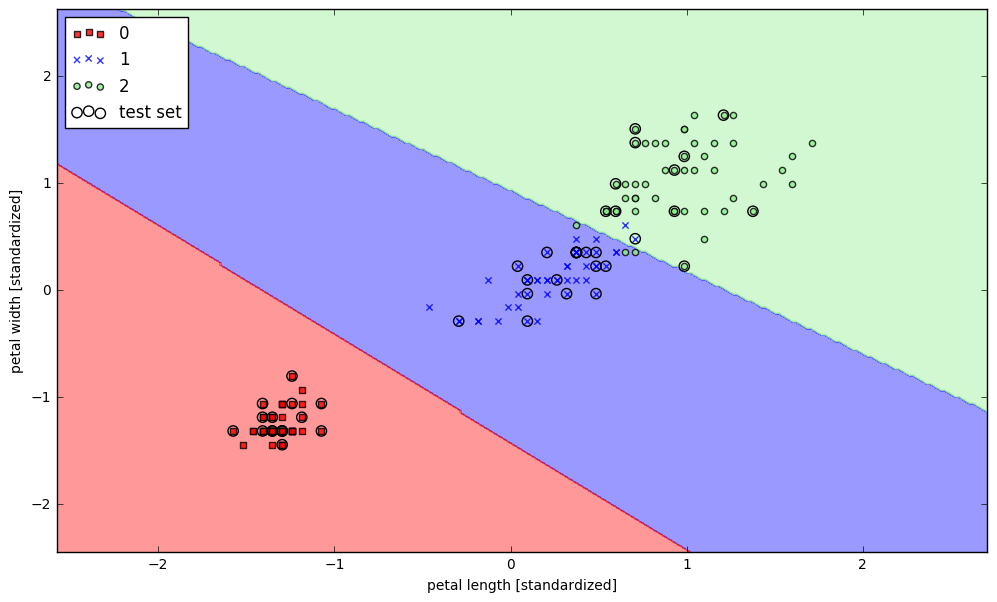

In [15]:
from sklearn.svm import SVC

svm = SVC(kernel="linear", C=1.0, random_state=0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

## Online Learning

Scikit-Learn natively supports online learning via the **SGDClassifier** **partial_fit** method.

In [16]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss="perceptron")
lr = SGDClassifier(loss="log")
svm = SGDClassifier(loss="hinge")

## Kernel SVM

SVM can solve nonlinear problems by using a kernel. To test it we will create a dataset

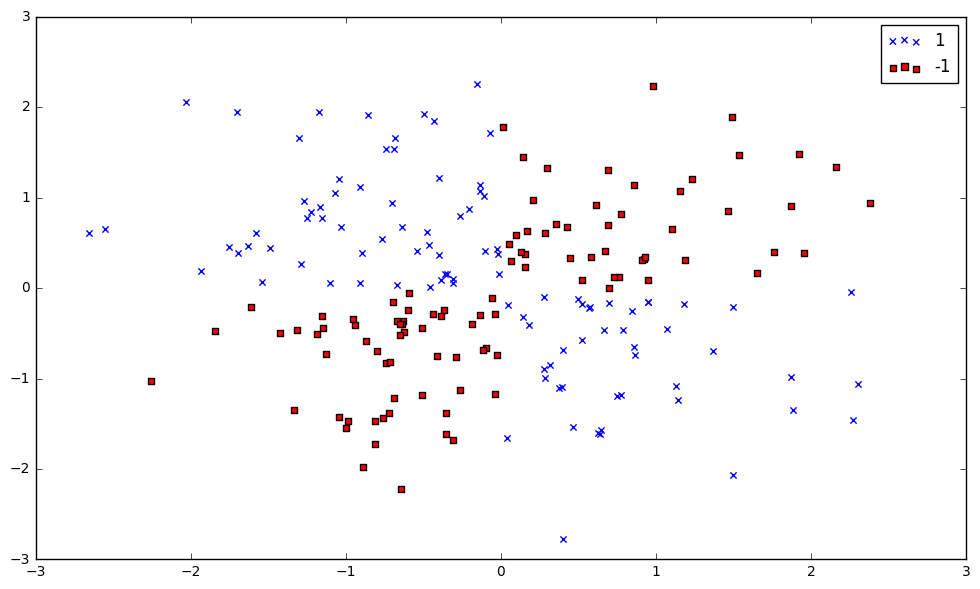

In [17]:
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c="b", marker="x", label="1")
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c="r", marker="s", label="-1")
plt.ylim(-3.0)
plt.legend()
plt.show()

Of course it is impossible to separate these classes with a linear function, the idea is to project via a kernel the features onto a higher dimensional space via a mapping function $\phi(.)$ where it becomes linearly separable.

Now we will try to separate these classes by using the **Radial Basis Function** (rbf) kernel

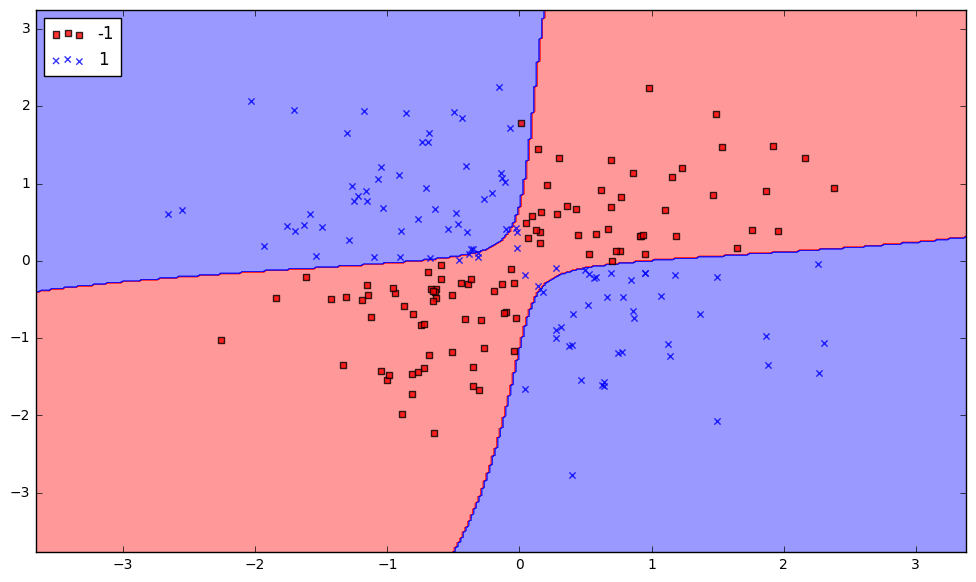

In [18]:
svm = SVC(kernel="rbf", random_state=0, gamma=0.1, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc="upper left")
plt.show()

The $\gamma$ (gamma) parameter which we set to 0.1 can be understood as a cut-off parameter for the Gaussian sphere. If we increase its value we increase the reach (or influence) of the training samples leading to a softer decision boundary.

To better understand $\gamma$ let's apply rbf to Iris data

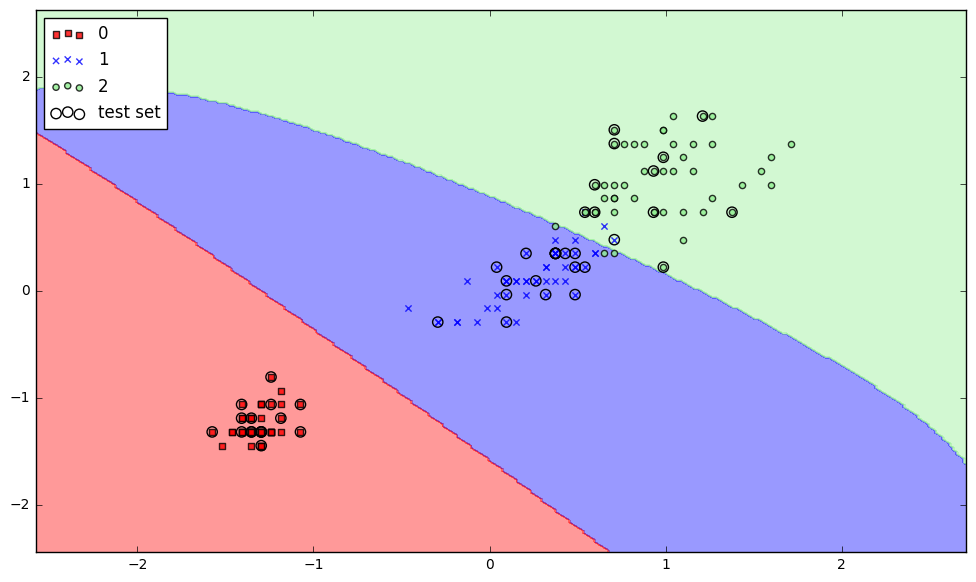

In [19]:
svm = SVC(kernel="rbf", random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.legend(loc="upper left")
plt.show()

Since we chose a relatively small value for $\gamma$ the decision boundary will be soft, let's see what happens by increasing it

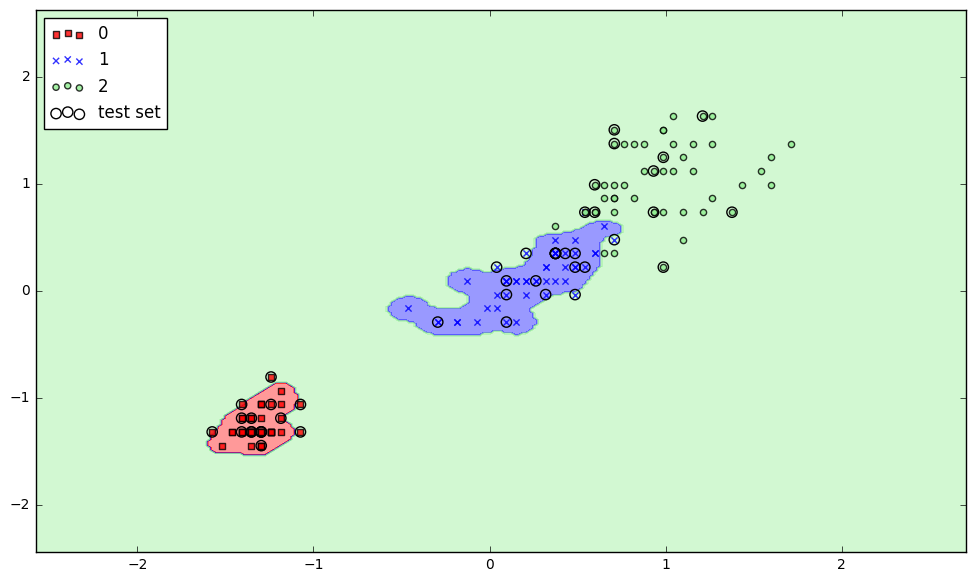

In [20]:
svm = SVC(kernel="rbf", random_state=0, gamma=100, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.legend(loc="upper left")
plt.show()

## Decision Tree Learning

With decision trees we build algorithms that split data according to binary questions, we start at the root and split the data on the feature that results on largest **Information Gain (IG)**. In an iterative process we repeat the procedure at each child node.

### Maximizing Information Gain

We have to define a function to maximize the IG at every split:

$$
IG(D_p,f)=I(D_p)-\sum_{j=1}^{m}\frac{N_j}{N_p}I(D_j)
$$

Where $f$ is the feature to perform the split, $D_p$ and $D_j$ are the dataset of the parent and *jth* child node, $I$ is our impurity measure, $N_p$ is the total number of samples at the parent node, and $N_j$ is the number of samples in the *jth* child node.

In order to reduce complexity and combinatorial search space, we implement binary decision trees, meaning that each parent node is split into $D_{left}$ and $D_{right}$, thus:

$$
IG(D_p, f)=I(D_p)-\frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})
$$

Usually the three impurity measures used are **Gini impurity** ($I_G$), **entropy** ($I_H$) and **classification error** ($I_E$).

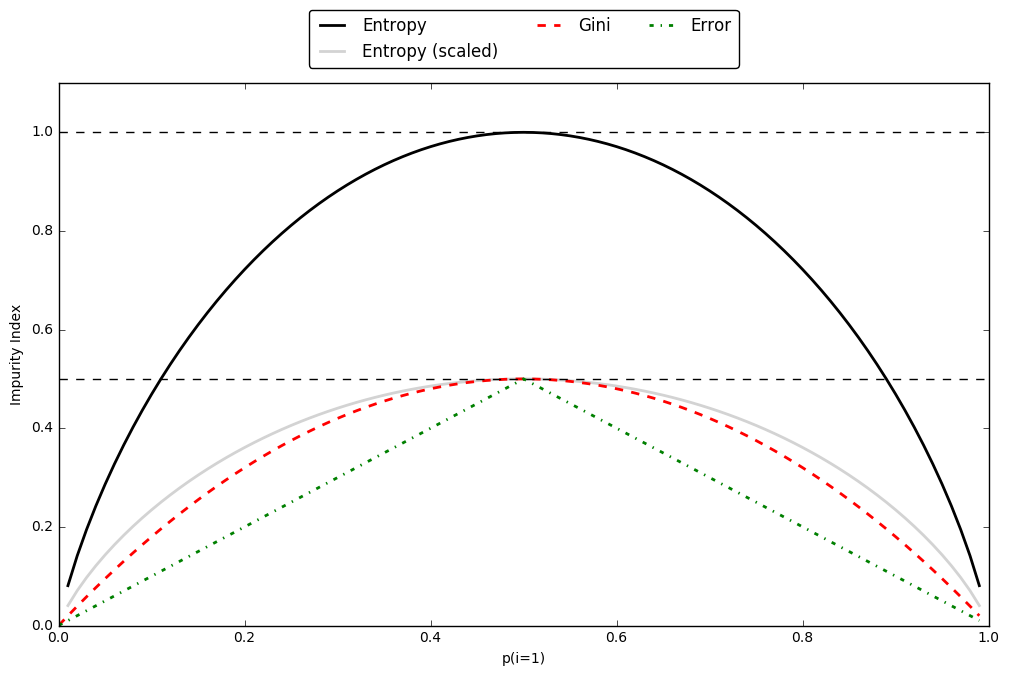

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams['figure.figsize'] = (12.0, 7.0)

def gini(p):
    return (p) * (1 - (p)) + (1 - p) * (1 - (1 - p))

def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err], ["Entropy", "Entropy (scaled)", "Gini", "Error"],
                        ["-", "-", "--", "-."], ["black", "lightgray", "red", "green", "cyan"]):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color="k", linestyle="--")
ax.axhline(y=1.0, linewidth=1, color="k", linestyle="--")
plt.ylim([0, 1.1])
plt.xlabel("p(i=1)")
plt.ylabel("Impurity Index")
plt.show()

Decision trees can build complex decision boundaries by dividing the feature space into rectangles, but we have to be careful to avoid overfitting by controlling the depth of the tree.

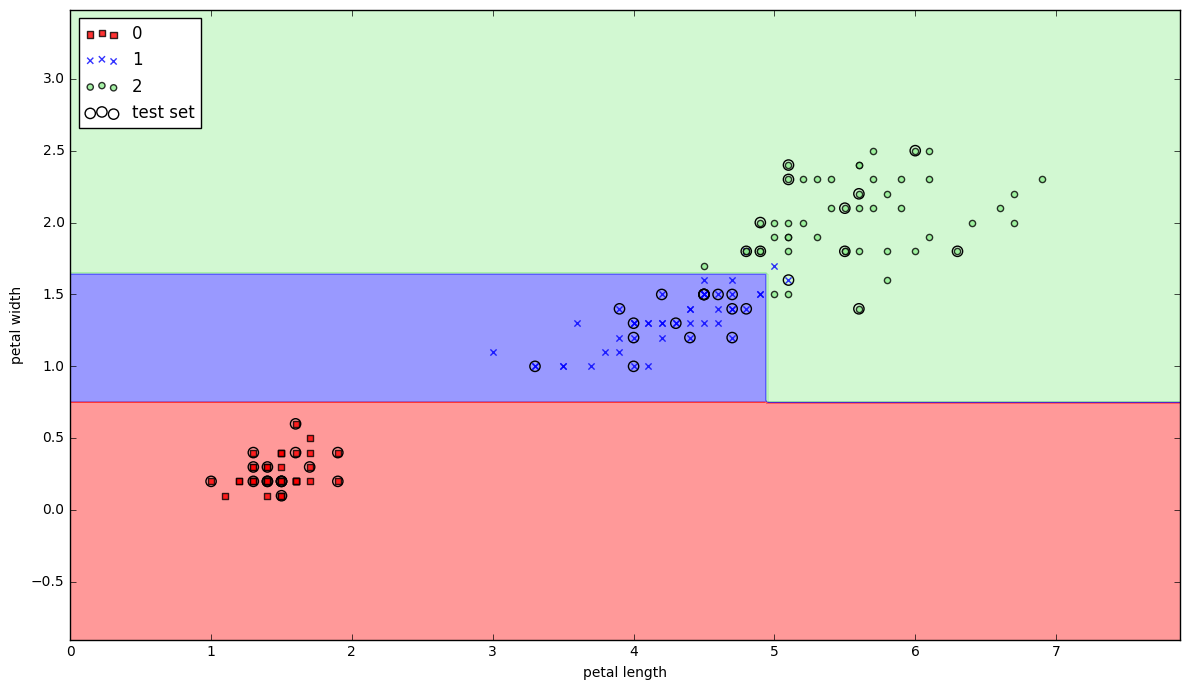

In [25]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=0)
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree, test_idx=range(105, 150))
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

## Random Forests

**Random Forests** is an ensemble learning algorithm working like this:

1. Draw a random **bootstrap** sample of size n
2. Grow a decision tree from the bootstrap sample, at each node:
    - Randomly select d features without replacement
    - Split the node using the feature that provides the best split
3. Repeat the steps 1 to 2 k times
4. Aggregate the prediction by each tree to assign the class label by **majority vote**

In step 2 instead of evaluating all features for the split, we only consider a random subset of those.

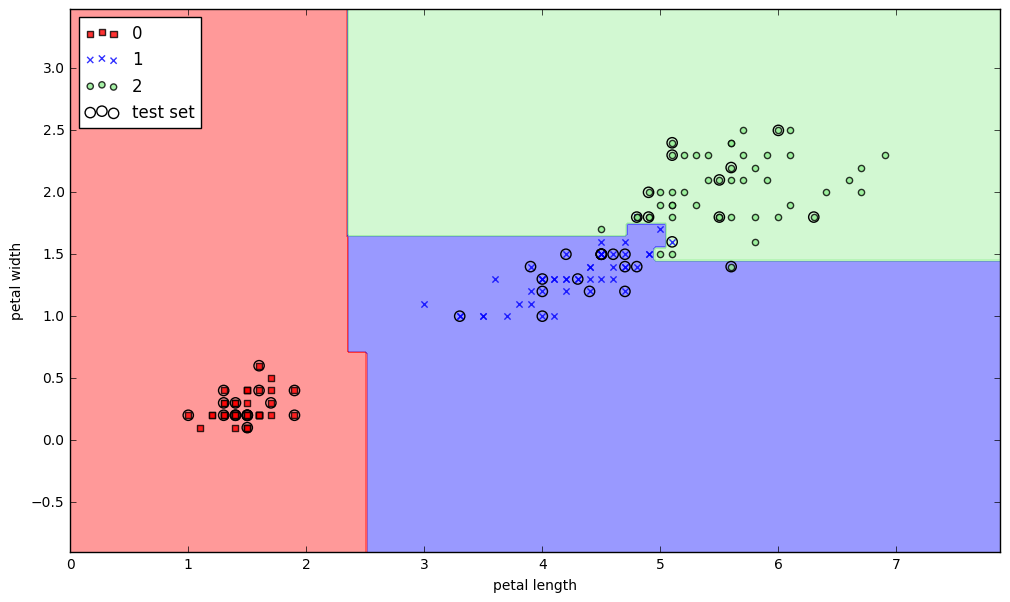

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion="entropy", n_estimators=10, random_state=1, n_jobs=2)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend(loc="upper left")
plt.show()

This a result of a forest trained from 10 decision trees (`n_estimators`) and used the entropy as a splitting criterion. With the `n_jobs`parameter we can parallelize the training, in this case we used two cores.

## KNN

**K-Nearest Neighbor Classifier** is a typical example of a lazy learner, it is lazy because it doesn't learn a discriminative function from train.ing data but memorizes the training dataset instead. The KNN algorithm can be summarized as:

1. Choose the number of k and a distance metric
2. Find the k nearest neighbors of the sample
3. Assign the class label by majority vote

The main advantage is that the classifier immediately adapts as we collect new training data, but the computational complexity for classifying new samples grows linearly with the number of samples in the training set.